In [1]:
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

In [2]:
MSIMUT = os.path.join('Dataset/train/MSIMUT/')
MSS = os.path.join('Dataset/train/MSS/')

In [3]:
print('total MSIMUT  images:', len(os.listdir(MSIMUT)))
print('total MSS images:', len(os.listdir(MSS)))

total MSIMUT  images: 60031
total MSS images: 93818


In [4]:
MSIMUT_names = os.listdir(MSIMUT)
print(MSIMUT_names[:5])
MSS_names = os.listdir(MSS)
print(MSS_names[:5])

['blk-AAADECQEWVSD-TCGA-CM-4746-01Z-00-DX1.jpg', 'blk-AAAFIYHTSVIE-TCGA-G4-6309-01Z-00-DX1.jpg', 'blk-AAAFQELPMPTI-TCGA-AA-3715-01Z-00-DX1.jpg', 'blk-AAAGNSGLEPNP-TCGA-CM-4746-01Z-00-DX1.jpg', 'blk-AAAHDPKQAIIV-TCGA-CK-5913-01Z-00-DX1.jpg']
['blk-AAADNFVSTKEF-TCGA-DC-6682-01Z-00-DX1.jpg', 'blk-AAAFDSIYEAPC-TCGA-AY-A71X-01Z-00-DX1.jpg', 'blk-AAAHVLHKARAN-TCGA-AY-A71X-01Z-00-DX1.jpg', 'blk-AAAIANVEVMQV-TCGA-DC-6683-01Z-00-DX1.jpg', 'blk-AAAMGKITFHHE-TCGA-F4-6809-01Z-00-DX1.jpg']


In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

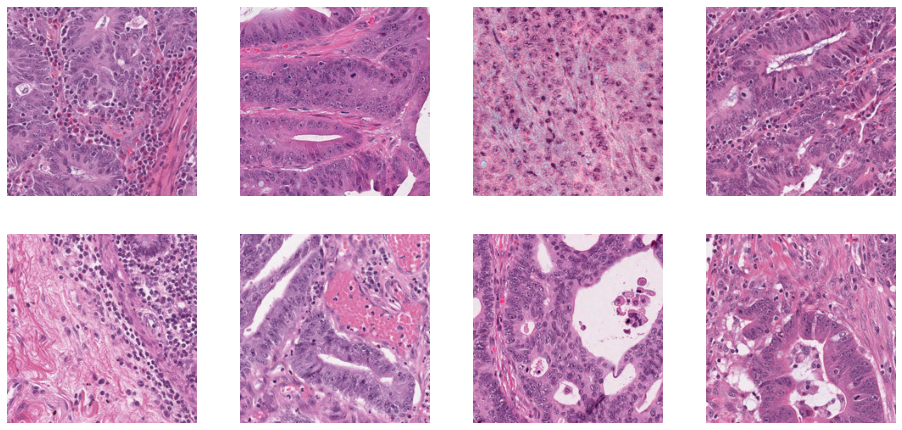

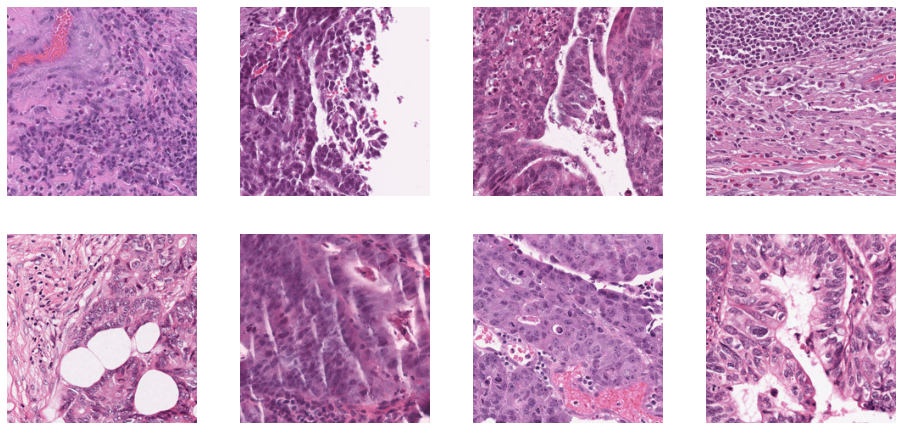

In [6]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
MSIMUT_pix = [os.path.join(MSIMUT, fname) 
                for fname in MSIMUT_names[pic_index-8:pic_index]]

MSS_pix = [os.path.join(MSS, fname) 
                for fname in MSS_names[pic_index-8:pic_index]]



print()
for i, img_path in enumerate(MSIMUT_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


print()
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
for i, img_path in enumerate(MSS_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img, cmap=plt.get_cmap('gray'))

plt.show()

In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [8]:
batch_size=64

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
data_generator = ImageDataGenerator(rescale=1/255,validation_split=0.2)

# Flow training images in batches of 128 using train_datagen generator
train_generator = data_generator.flow_from_directory(
        'Dataset/train/',  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 224 x 224
        batch_size=batch_size,
        # Specify the classes explicitly
        classes = ['MSIMUT','MSS'],
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='binary',subset="training")

test_generator = data_generator.flow_from_directory(
        'Dataset/train/',  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 224 x 224
        batch_size=batch_size,
        # Specify the classes explicitly
        classes = ['MSIMUT','MSS'],
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='binary',subset="validation")

Found 123080 images belonging to 2 classes.
Found 30769 images belonging to 2 classes.


In [10]:
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = True

In [11]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [12]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(1, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                2560050   
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 24,363,875
Trainable params: 24,329,443
Non-trainable params: 34,432
_________________________________________________________________


In [14]:
import tensorflow as tf

In [15]:
from tensorflow.keras.optimizers import RMSprop

In [16]:
model.compile(
    optimizer=RMSprop(lr=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)


In [22]:
total_sample=train_generator.n
n_epochs=30

In [19]:
total_sample

123080

In [20]:
123080/64

1923.125

In [18]:
history = model.fit_generator(
        train_generator, 
        steps_per_epoch=10,  
        epochs=n_epochs,
        verbose=1)

Epoch 1/30
200/200 [==============================] - 54m 7s/step - loss: 1.4677 - accuracy: 0.6001
Epoch 2/30
200/200 [==============================] - 57m 9s/step - loss: 1.3759 - accuracy: 0.5921
Epoch 3/30
200/200 [==============================] - 53m 7s/step - loss: 1.2911 - accuracy: 0.5827
Epoch 4/30
200/200 [==============================] - 61m 9s/step - loss: 1.2689 - accuracy: 0.6278
Epoch 5/30
200/200 [==============================] - 58m 8s/step - loss: 1.2547 - accuracy: 0.6377
Epoch 6/30
200/200 [==============================] - 65m 9s/step - loss: 1.2492 - accuracy: 0.6128
Epoch 7/30
200/200 [==============================] - 55m 7s/step - loss: 1.2387 - accuracy: 0.6242
Epoch 8/30
200/200 [==============================] - 63m 9s/step - loss: 1.2296 - accuracy: 0.6289
Epoch 9/30
200/200 [==============================] - 64m 9s/step - loss: 1.2253 - accuracy: 0.6312
Epoch 10/30
200/200 [==============================] - 58m 7s/step - loss: 1.2007 - accuracy: 0.6354

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Training accuracy

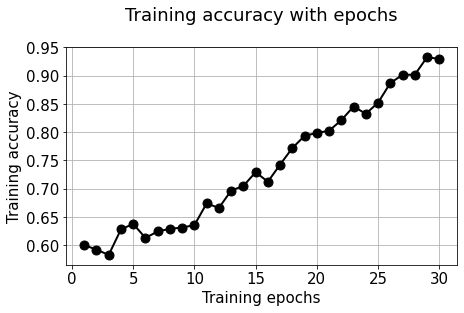

In [29]:
plt.figure(figsize=(7,4))
plt.plot([i+1 for i in range(n_epochs)],history.history['accuracy'],'-o',c='k',lw=2,markersize=9)
plt.grid(True)
plt.title("Training accuracy with epochs\n",fontsize=18)
plt.xlabel("Training epochs",fontsize=15)
plt.ylabel("Training accuracy",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Training loss

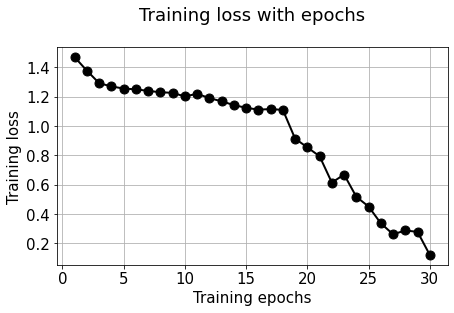

In [33]:
plt.figure(figsize=(7,4))
plt.plot([i+1 for i in range(n_epochs)],history.history['loss'],'-o',c='k',lw=2,markersize=9)
plt.grid(True)
plt.title("Training loss with epochs\n",fontsize=18)
plt.xlabel("Training epochs",fontsize=15)
plt.ylabel("Training loss",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Saving the model weights

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
predict_x=model.predict(test_generator, verbose=1) 

predicted_class=np.argmax(predict_x,axis=1)
original_class=test_generator.labels
mobilenet=accuracy_score(original_class,predicted_class)*100
print("Test set accuracy "+str(mobilenet))

## Saving the model

In [27]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [28]:
# serialize weights to HDF5
model.save_weights('trained_weights.h5')
print("Saved model to disk")

Saved model to disk


## Prediction from the single image

In [29]:
from keras.models import model_from_json

In [30]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("trained_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [32]:
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

In [33]:
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
file_name='sample.jpg'
my_image=0
#load the image
my_image = load_img(file_name, target_size=(224, 224))

#preprocess the image
my_image = img_to_array(my_image)
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
my_image = preprocess_input(my_image)

In [34]:
result=loaded_model.predict(my_image)
import numpy as np
class_value=np.argmax(result)

In [35]:
if(class_value==0):
    print("The given image was MSIMUT class")
elif(class_value==1):
    print("The given image was MSS class")

The given image was MSIMUT class
